# Notebook setup

In [1]:
#Set up packages
import pandas as pd
import numpy as np
from drg_connect import Snowflake
import qgrid
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

snow = Snowflake(role = 'RWD_RESERVED_1',database='project_analytics',warehouse= 'rwd_wh_reserved_1', schema = 'PUBLIC')
engine = snow.engine

#Set up sql_magic settings
%reload_ext sql_magic
%config SQL.output_result = True  #Enable output to std out
%config SQL.notify_result = False #disable browser notifications
%config SQL.conn_name = 'engine'  #Set the sql_magic connection engine


#Set pandas to display up to 100 rows and 50 columns
pd.set_option("display.max_rows",100,"display.max_columns",50)

#Change your output to allow for multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Stabilization - 2018

## Claims from Submits header

In [3]:
%%read_sql

CREATE  or replace TRANSIENT TABLE PRIY_SUBMIT_HEADER_2018 AS 
SELECT DISTINCT
    ENCRYPTED_KEY_1,
    ENCRYPTED_KEY_2,
    PATIENT_ID,
    CLAIM_NUMBER,
    CLAIM_ID,
   year_of_service
FROM  rwd_db.RWD.RAVEN_CLAIMS_SUBMITS_HEADER H 
WHERE YEAR(YEAR_OF_SERVICE) =2018 AND
      ENCRYPTED_KEY_1 <>'NULL' AND 
      ENCRYPTED_KEY_1 NOT LIKE 'XXX - %' AND
      ENCRYPTED_KEY_1 IS NOT NULL AND ENCRYPTED_KEY_1 <> ''
  AND ENCRYPTED_KEY_2 <>'NULL' AND 
      ENCRYPTED_KEY_2 NOT LIKE 'XXX - %' AND
      ENCRYPTED_KEY_2 IS NOT NULL AND ENCRYPTED_KEY_2 <> '';

GRANT OWNERSHIP ON TABLE PRIY_SUBMIT_HEADER_2018 TO ROLE RWD_ANALYTICS_RW;

Query started at 05:13:37 PM India Standard Time; Query executed in 5.70 mQuery started at 05:19:19 PM India Standard Time; Query executed in 0.05 m

status
0  Statement executed successfully.

In [67]:
%%read_sql
SELECT COUNT(DISTINCT PATIENT_ID) FROM PRIY_SUBMIT_HEADER_2018;

Query started at 02:30:40 AM India Standard Time; Query executed in 0.64 m

COUNT(DISTINCT PATIENT_ID)
0                   159509860

## Identify healthbase ID

### For claims with organizational NPI

In [5]:
%%read_sql

create or replace TRANSIENT table PRIY_SUBMIT_HEADER_2018_2 AS
SELECT DISTINCT A.*,
                B.ORGANIZATION_NPI,
                HB.HEALTHBASE_ID,
                COALESCE(B.ORGANIZATION_LABEL,HB.LABEL) AS LABEL
FROM PRIY_SUBMIT_HEADER_2018 A
JOIN project_analytics.reference.CLAIMS_SUBMITS_FACILITY_MASTER_NEW B
ON A.CLAIM_NUMBER = B.CLAIM_NUMBER
JOIN rwd_db.RWD.HEALTHBASE_ENTITYLOOKUP HB
ON B.ORGANIZATION_NPI = HB.IDENTIFIER;

GRANT OWNERSHIP ON TABLE PRIY_SUBMIT_HEADER_2018_2 TO ROLE RWD_ANALYTICS_RW;

Query started at 06:14:18 PM India Standard Time; Query executed in 11.82 mQuery started at 06:26:07 PM India Standard Time; Query executed in 0.05 m

status
0  Statement executed successfully.

In [77]:
%%read_sql

-- SELECT COUNT(DISTINCT CLAIM_NUMBER) FROM PRIY_SUBMIT_HEADER_2018; --1,329,033,521

-- SELECT COUNT(DISTINCT CLAIM_NUMBER) FROM PRIY_SUBMIT_HEADER_2018_2
-- WHERE HEALTHBASE_ID IS NOT NULL; --1,228,425,302

-- 92% claims have healthbase IDs based on organizational NPIs

SELECT COUNT(DISTINCT HEALTHBASE_ID) FROM PRIY_SUBMIT_HEADER_2018_2; -- 625,484

Query started at 06:47:12 PM India Standard Time; Query executed in 0.27 m

COUNT(DISTINCT HEALTHBASE_ID)
0                         625484

### For claims without organizational NPI

In [6]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_3 as
select A.*
from PRIY_SUBMIT_HEADER_2018 A
where A.claim_number not in (select claim_number
                             from PRIY_SUBMIT_HEADER_2018_2);

Query started at 06:29:42 PM India Standard Time; Query executed in 1.99 m

status
0  Table PRIY_SUBMIT_HEADER_2018_3 successfully c...

USe provider NPI

In [7]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_4 as
select A.*,
       B.provider_type,
       B.provider_npi,
       case when B.provider_type = 'Facility' 
					or B.provider_type = 'ServiceLocation'
					then 1
				when B.provider_type = 'Billing'
					then 2
				when B.provider_type = 'Attending'
					then 3
				when B.provider_type = 'Rendering'
					then 4
				else 5
				end as provider_priority
from PRIY_SUBMIT_HEADER_2018_3 A
inner join (select provider_type, provider_npi, CLAIM_ID
            from rwd_db.RWD.RAVEN_CLAIMS_SUBMITS_PROVIDER
            where provider_npi is not null
           ) B
on A.CLAIM_ID = B.CLAIM_ID;

Query started at 06:32:21 PM India Standard Time; Query executed in 3.15 m

status
0  Table PRIY_SUBMIT_HEADER_2018_4 successfully c...

Pick single NPI per claim

In [10]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_5 as

with T1 as (

SELECT  ENCRYPTED_KEY_1,
        ENCRYPTED_KEY_2,
        PATIENT_ID,
        CLAIM_NUMBER,
        CLAIM_ID,
       year_of_service,
       PROVIDER_NPI as organization_npi,
       row_number() over(partition by CLAIM_ID order by PROVIDER_PRIORITY asc) as rnk
    from PRIY_SUBMIT_HEADER_2018_4

)

SELECT  ENCRYPTED_KEY_1,
        ENCRYPTED_KEY_2,
        PATIENT_ID,
        CLAIM_NUMBER,
        CLAIM_ID,
       year_of_service,
       organization_npI  
from T1
where rnk = 1;

Query started at 06:38:18 PM India Standard Time; Query executed in 1.14 m

status
0  Table PRIY_SUBMIT_HEADER_2018_5 successfully c...

Get healthbase ID

In [11]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_6 as
select A.*
		,  HB.HEALTHBASE_ID
        ,  HB.LABEL
from PRIY_SUBMIT_HEADER_2018_5 A
inner JOIN rwd_db.RWD.HEALTHBASE_ENTITYLOOKUP HB
ON A.ORGANIZATION_NPI = HB.IDENTIFIER; 

Query started at 06:39:26 PM India Standard Time; Query executed in 0.83 m

status
0  Table PRIY_SUBMIT_HEADER_2018_6 successfully c...

### Combine both sets

In [13]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_7 as

select ENCRYPTED_KEY_1,
        ENCRYPTED_KEY_2,
        PATIENT_ID,
        CLAIM_NUMBER,
        CLAIM_ID,
        YEAR_OF_SERVICE,
        ORGANIZATION_NPI,
        HEALTHBASE_ID,
        LABEL,
       year(year_of_service) as year,
       quarter(year_of_service) as quarter,
       month(year_of_service) as month,
       'ORGANIZATION_NPI' as healthbase_id_src 
from PRIY_SUBMIT_HEADER_2018_2

UNION ALL 

select ENCRYPTED_KEY_1,
        ENCRYPTED_KEY_2,
        PATIENT_ID,
        CLAIM_NUMBER,
        CLAIM_ID,
        YEAR_OF_SERVICE,
        ORGANIZATION_NPI,
        HEALTHBASE_ID,
        LABEL,
       year(year_of_service) as year,
       quarter(year_of_service) as quarter,
       month(year_of_service) as month,
       'PROVIDER_NPI' as healthbase_id_src 
from PRIY_SUBMIT_HEADER_2018_6;

GRANT ownership ON TABLE PRIY_SUBMIT_HEADER_2018_7 TO ROLE RWD_analytics_rw;

Query started at 06:45:24 PM India Standard Time; Query executed in 2.57 mQuery started at 06:47:58 PM India Standard Time; Query executed in 0.05 m

status
0  Statement executed successfully.

## Patient demographics

In [15]:
%%read_sql
SHOW VIEWS LIKE 'raven_patient_demographics' IN RWD_DB.RWD;

Query started at 06:48:34 PM India Standard Time; Query executed in 0.15 m

created_on                        name reserved  \
0 2019-01-23 10:40:52.425000+00:00  RAVEN_PATIENT_DEMOGRAPHICS            

  database_name schema_name    owner comment  \
0        RWD_DB         RWD  RWD_ETL           

                                                text is_secure  
0  create or replace view RWD_DB.RWD.RAVEN_PATIEN...     false

### Age and gender from demographics table

In [16]:
%%read_sql

create or replace transient table PRIY_SUBMIT_HEADER_2018_8 as
SELECT DISTINCT A.*,
        B.GENDER,
        B.DATE_OF_BIRTH,
        datediff(year, B.DATE_OF_BIRTH, A.year_of_service) AS AGE
FROM PRIY_SUBMIT_HEADER_2018_7 AS A
LEFT JOIN
rwd_db.rwd.raven_patient_demographics AS B
ON A.PATIENT_ID=B.PATIENT_ID;

begin;

UPDATE PRIY_SUBMIT_HEADER_2018_8
SET GENDER = NULL 
WHERE GENDER='X';

commit;

begin;

UPDATE PRIY_SUBMIT_HEADER_2018_8
SET DATE_OF_BIRTH = NULL 
WHERE AGE<0;

commit;


Query started at 06:49:14 PM India Standard Time; Query executed in 9.98 m

status
0  Table PRIY_SUBMIT_HEADER_2018_8 successfully c...

### Patient geography plus age and state for remaining patients

In [22]:
%%read_sql
CREATE OR REPLACE TABLE PRIY_SUBMIT_HEADER_2018_9 AS

with T1 as (SELECT DISTINCT A.*,
                            COALESCE(A.DATE_OF_BIRTH, B.Patient_DOB) AS Patient_DOB,
                            datediff(year, COALESCE(A.DATE_OF_BIRTH, B.Patient_DOB), A.year_of_service) AS PATIENT_AGE,
                            CASE    WHEN PATIENT_AGE >= 0 AND PATIENT_AGE <= 19 THEN '0-19' 
                                WHEN PATIENT_AGE >= 20 AND PATIENT_AGE <= 34 THEN '20-34'
                                WHEN PATIENT_AGE >= 35 AND PATIENT_AGE <= 49 THEN '35-49'
                                WHEN PATIENT_AGE >= 50 AND PATIENT_AGE <= 64 THEN '50-64'
                                WHEN PATIENT_AGE >= 65 THEN '65+' END AS PATIENT_AGE_GROUP,
                            COALESCE(A.GENDER, B.PATIENT_GENDER) AS PATIENT_GENDER,
                            B.MEMBER_ADR_STATE AS PATIENT_STATE,
                            B.MEMBER_ADR_ZIP AS PATIENT_ZIP,
                            case when B.payer_sequence = 0 then NULL
                                 else B.payer_sequence end as payer_sequence
            
FROM PRIY_SUBMIT_HEADER_2018_8 AS A
LEFT JOIN rwd_db.RWD.RAVEN_CLAIMS_SUBMITS_PATIENT B
ON A.CLAIM_ID = B.CLAIM_ID AND A.PATIENT_ID = B.PATIENT_ID
)

select * from T1
where PATIENT_AGE is not null and PATIENT_AGE >= 0 AND
      PATIENT_GENDER not in ('U','X');


Query started at 07:24:22 PM India Standard Time; Query executed in 21.32 m

status
0  Table PRIY_SUBMIT_HEADER_2018_9 successfully c...

#### Cleaning state values

In [25]:
%%read_sql

create or replace table PRIY_SUBMIT_HEADER_2018_10 AS

WITH T1 AS
(select YEAR,
     PATIENT_ID, 
     PATIENT_STATE, 
     YEAR_OF_SERVICE,
     payer_sequence
FROM PRIY_SUBMIT_HEADER_2018_9
WHERE PATIENT_STATE IN 
(select distinct state_x from RWD_DB.THIRD_PARTY.ZIP3STATEMAP)),

T2 as (select YEAR, 
           PATIENT_ID,
           PATIENT_STATE,
           YEAR_OF_SERVICE,
           payer_sequence,
           row_number() over(partition by YEAR, PATIENT_ID 
                             order by YEAR_OF_SERVICE desc, payer_sequence asc nulls last) as rnk
            from T1)
            
SELECT A.*,
       B.PATIENT_STATE as PATIENT_STATE_FIXED,
       C.interstate_regions AS REGION
FROM PRIY_SUBMIT_HEADER_2018_9 A
INNER join (select distinct YEAR, PATIENT_ID, PATIENT_STATE from T2 where rnk = 1) B
on A.year = B.year AND
   A.patient_id = B.patient_id
   
LEFT JOIN
REF_DB.ANALYTICS.STATE_TO_REGION AS C
ON UPPER(TRIM(B.PATIENT_STATE)) = UPPER(TRIM(C.STATE))
;
   
GRANT ownership ON TABLE PRIY_SUBMIT_HEADER_2018_10 TO ROLE RWD_analytics_rw;

Query started at 08:12:17 PM India Standard Time; Query executed in 6.61 mQuery started at 08:18:54 PM India Standard Time; Query executed in 0.04 m

status
0  Statement executed successfully.

# Stabilization

In [26]:
%%read_sql

create or replace TRANSIENT table PRIY_STABL_METRICS_2018_1 as

select HEALTHBASE_ID,
       year,
       quarter,
       month,       
       count(distinct CLAIM_ID) as claim_cnt,
       count(distinct PATIENT_ID) as patient_cnt
       
from PRIY_SUBMIT_HEADER_2018_10
group by HEALTHBASE_ID, year, quarter, month;

Query started at 08:18:56 PM India Standard Time; Query executed in 1.39 m

status
0  Table PRIY_STABL_METRICS_2018_1 successfully c...

## Healthbase ID metrics

In [27]:
%%read_sql

create or replace TRANSIENT table PRIY_STABL_METRICS_2018_2 as

select year, 
       HEALTHBASE_ID,
       count(*) as month_cnt,
       max(claim_cnt) as claim_cnt_max,
       min(claim_cnt) as claim_cnt_min,
       avg(claim_cnt) as claim_cnt_avg,
       median(claim_cnt) as claim_cnt_median,
       stddev(claim_cnt) as claim_cnt_stddev,
       round(claim_cnt_stddev/claim_cnt_avg, 2) as claim_cnt_cv
from PRIY_STABL_METRICS_2018_1

group by year, HEALTHBASE_ID;

Query started at 08:20:20 PM India Standard Time; Query executed in 0.09 m

status
0  Table PRIY_STABL_METRICS_2018_2 successfully c...

### Plot hists

In [28]:
%%read_sql -d CLAIM_METRICS
SELECT * FROM PRIY_STABL_METRICS_2018_2;

Query started at 08:42:28 PM India Standard Time; Query executed in 0.69 m

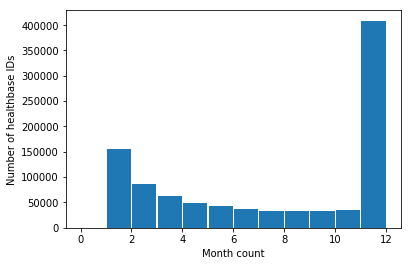

In [29]:
bin_edges = [0,1,2,3,4,5,6,7,8,9,10,11,12]

_ = plt.hist(CLAIM_METRICS['month_cnt'], bins=bin_edges, rwidth=0.95, )
_ = plt.xlabel('Month count')
_ = plt.ylabel('Number of healthbase IDs')

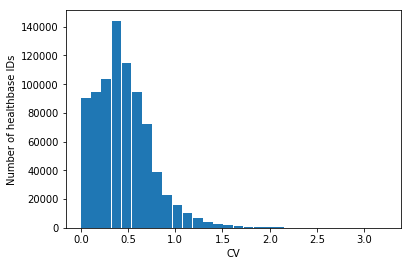

In [30]:
new_CLAIM_METRICS = CLAIM_METRICS[~np.isnan(CLAIM_METRICS['claim_cnt_cv'])]
_ = plt.hist(new_CLAIM_METRICS['claim_cnt_cv'], bins=30,rwidth=0.95)
_ = plt.xlabel('CV')
_ = plt.ylabel('Number of healthbase IDs')

## Parameters about CV

In [31]:
%%read_sql

select year,
       max(claim_cnt_cv) as max_cv,
       min(claim_cnt_cv) as min_cv,
       avg(claim_cnt_cv) as avg_cv,
       median(claim_cnt_cv) as median_cv,
       stddev(claim_cnt_cv) as stddev_cv,
       (median_cv + 1*stddev_cv) as upper_range_cv_1,
       (median_cv - 1*stddev_cv) as lower_range_cv_1,
       (median_cv + 2*stddev_cv) as upper_range_cv_2,
       (median_cv - 2*stddev_cv) as lower_range_cv_2
       
from PRIY_STABL_METRICS_2018_2
group by year;

Query started at 08:46:20 PM India Standard Time; Query executed in 0.13 m

year  max_cv  min_cv    avg_cv  median_cv  stddev_cv  upper_range_cv_1  \
0  2018    3.23     0.0  0.448983       0.42   0.304465          0.724465   

   lower_range_cv_1  upper_range_cv_2  lower_range_cv_2  
0          0.115535          1.028929         -0.188929

## Join Back parameters to unstabilized

In [32]:
%%read_sql

create or replace table PRIY_SUBMIT_HEADER_2018_11 as

select A.*,
       B.month_cnt,
       B.claim_cnt_max,
       B.claim_cnt_min,
       B.claim_cnt_avg,
       B.claim_cnt_median,
       B.claim_cnt_stddev,
       B.claim_cnt_cv

from PRIY_SUBMIT_HEADER_2018_10 A
left join PRIY_STABL_METRICS_2018_2 B
on A.HEALTHBASE_ID = B.HEALTHBASE_ID AND A.year = B.year;

GRANT ownership ON TABLE PRIY_SUBMIT_HEADER_2018_11 TO ROLE RWD_analytics_rw;

Query started at 08:47:59 PM India Standard Time; Query executed in 4.27 mQuery started at 08:52:15 PM India Standard Time; Query executed in 0.04 m

status
0  Statement executed successfully.

## Stabilized data

In [38]:
%%read_sql

CREATE OR REPLACE TABLE PRIY_SUBMIT_HEADER_STABL_2018 AS
SELECT *
FROM PRIY_SUBMIT_HEADER_2018_11
WHERE month_cnt>=12 AND  claim_cnt_cv<=0.7 AND claim_cnt_cv IS NOT NULL;

GRANT ownership ON TABLE PRIY_SUBMIT_HEADER_STABL_2018 TO ROLE RWD_analytics_rw;

Query started at 11:43:43 PM India Standard Time; Query executed in 2.45 mQuery started at 11:46:10 PM India Standard Time; Query executed in 0.15 m

status
0  Statement executed successfully.

In [39]:
%%read_sql
SELECT COUNT(DISTINCt PATIENT_ID) FROM PRIY_SUBMIT_HEADER_STABL_2018;

Query started at 11:46:55 PM India Standard Time; Query executed in 0.28 m

COUNT(DISTINCT PATIENT_ID)
0                   151455156

# US population projection

In [72]:
%%read_sql
SELECT * FROM PROJECT_ANALYTICS.HERON_BUPMEL.CENSUS_2010_2017;

Query started at 06:28:20 PM India Standard Time

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\priyanka\AppData\Local\Continuum\anaconda3\lib\site-packages\snowflake\connector\network.py", line 336, in _renew_session
    return self._token_request(REQUEST_TYPE_RENEW)
  File "C:\Users\priyanka\AppData\Local\Continuum\anaconda3\lib\site-packages\snowflake\connector\network.py", line 412, in _token_request
    sqlstate=SQLSTATE_CONNECTION_WAS_NOT_ESTABLISHED))
snowflake.connector.network.ReauthenticationRequest: 390114 (08001): Authentication token has expired.  The user must authenticate again.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\priyanka\AppData\Local\Continuum\anaconda3\lib\site-packages\sqlalchemy\pool.py", line 712, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\priyanka\AppData\Local\Continuum\anaconda3\lib\site-packages\sqlalchemy\pool.py", line 883, in _reset
    pool._dialect.do_rollback(self

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
; Query executed in 0.58 m

sumlev  region  division  state    name  sex  origin  race  age  \
0           40       2         4     20  Kansas    1       1     5   16   
1           40       2         4     20  Kansas    1       1     5   17   
2           40       2         4     20  Kansas    1       1     5   18   
3           40       2         4     20  Kansas    1       1     5   19   
4           40       2         4     20  Kansas    1       1     5   20   
5           40       2         4     20  Kansas    1       1     5   21   
6           40       2         4     20  Kansas    1       1     5   22   
7           40       2         4     20  Kansas    1       1     5   23   
8           40       2         4     20  Kansas    1       1     5   24   
9           40       2         4     20  Kansas    1       1     5   25   
10          40       2         4     20  Kansas    1       1     5   26   
11          40       2         4     20  Kansas    1       1     5   27   
12          40       2         4     20  Kansas    1       1     5   28   
13          40       2         4     20  Kansas    1       1     5   29   
14          40       2         4     20  Kansas    1       1     5   30   
15          40       2         4     20  Kansas    1       1     5   31   
16          40       2         4     20  Kansas    1       1     5   32   
17          40       2         4     20  Kansas    1       1     5   33   
18          40       2         4     20  Kansas    1       1     5   34   
19          40       2         4     20  Kansas    1       1     5   35   
20          40       2         4     20  Kansas    1       1     5   36   
21          40       2         4     20  Kansas    1       1     5   37   
22          40       2         4     20  Kansas    1       1     5   38   
23          40       2         4     20  Kansas    1       1     5   39   
24          40       2         4     20  Kansas    1       1     5   40   
25          40       2         4     20  Kansas    1       1     5   41   
26          40       2         4     20  Kansas    1       1     5   42   
27          40       2         4     20  Kansas    1       1     5   43   
28          40       2         4     20  Kansas    1       1     5   44   
29          40       2         4     20  Kansas    1       1     5   45   
30          40       2         4     20  Kansas    1       1     5   46   
31          40       2         4     20  Kansas    1       1     5   47   
32          40       2         4     20  Kansas    1       1     5   48   
33          40       2         4     20  Kansas    1       1     5   49   
34          40       2         4     20  Kansas    1       1     5   50   
35          40       2         4     20  Kansas    1       1     5   51   
36          40       2         4     20  Kansas    1       1     5   52   
37          40       2         4     20  Kansas    1       1     5   53   
38          40       2         4     20  Kansas    1       1     5   54   
39          40       2         4     20  Kansas    1       1     5   55   
40          40       2         4     20  Kansas    1       1     5   56   
41          40       2         4     20  Kansas    1       1     5   57   
42          40       2         4     20  Kansas    1       1     5   58   
43          40       2         4     20  Kansas    1       1     5   59   
44          40       2         4     20  Kansas    1       1     5   60   
45          40       2         4     20  Kansas    1       1     5   61   
46          40       2         4     20  Kansas    1       1     5   62   
47          40       2         4     20  Kansas    1       1     5   63   
48          40       2         4     20  Kansas    1       1     5   64   
49          40       2         4     20  Kansas    1       1     5   65   
...        ...     ...       ...    ...     ...  ...     ...   ...  ...   
197320      40       2         4     20  Kansas    1       1     4   52   
197321      40       2         4 

In [58]:
%%read_sql

CREATE OR REPLACE TABLE US_CENSUS_POP_ESTIMATE_2010_2018 AS
SELECT      CENSUS.NAME AS STATE,
            STATES_XW.ABBREVIATION AS STATES_ABBR,
            C.interstate_regions AS REGION,
            CASE WHEN CENSUS.SEX=1 THEN 'M'
            WHEN CENSUS.SEX=2 THEN 'F'
            END AS GENDER,
            
            
           CASE WHEN CENSUS.AGE >= 0 AND CENSUS.AGE <= 19 THEN '0-19' 
                WHEN CENSUS.AGE >= 20 AND CENSUS.AGE <= 34 THEN '20-34'
                WHEN CENSUS.AGE >= 35 AND CENSUS.AGE <= 49 THEN '35-49'
                WHEN CENSUS.AGE >= 50 AND CENSUS.AGE <= 64 THEN '50-64'
                WHEN CENSUS.AGE >= 65 THEN '65+' END AS AGE_GROUP,
                
            SUM(popestimate2010) AS cat_popestimate2010,
            SUM(popestimate2011) AS cat_popestimate2011,
            SUM(popestimate2012) AS cat_popestimate2012,
            SUM(popestimate2013) AS cat_popestimate2013,
            SUM(popestimate2014) AS cat_popestimate2014,
            SUM(popestimate2015) AS cat_popestimate2015,
            SUM(popestimate2016) AS cat_popestimate2016,
            SUM(popestimate2017) AS cat_popestimate2017,
            (cat_popestimate2017-cat_popestimate2016)/cat_popestimate2016 AS POPULATION_GROWTH,
            ROUND(cat_popestimate2017*(1+POPULATION_GROWTH)) AS cat_popestimate2018
FROM (SELECT * FROM PROJECT_ANALYTICS.HERON_BUPMEL.CENSUS_2010_2017 
      WHERE ORIGIN = 0
         AND SEX IN (1,2)) AS CENSUS  
         
LEFT JOIN  PROJECT_ANALYTICS.HERON_BUPMEL.STATES_ABBR_XWALK STATES_XW
ON         UPPER(TRIM(CENSUS.NAME)) = UPPER(TRIM(STATES_XW.STATE))

LEFT JOIN 
REF_DB.ANALYTICS.STATE_TO_REGION AS C
ON UPPER(TRIM(STATES_XW.ABBREVIATION)) = UPPER(TRIM(C.STATE))

GROUP BY 1,2,3,4,5
ORDER BY 1,2,3,4,5;    

GRANT OWNERSHIP ON TABLE US_CENSUS_POP_ESTIMATE_2010_2018 TO ROLE RWD_analytics_rw;

Query started at 02:13:18 AM India Standard Time; Query executed in 0.09 mQuery started at 02:13:23 AM India Standard Time; Query executed in 0.07 m

status
0  Statement executed successfully.

In [59]:
%%read_sql
SELECT * FROM US_CENSUS_POP_ESTIMATE_2010_2018;

Query started at 02:13:33 AM India Standard Time; Query executed in 0.10 m

state states_abbr      region gender age_group  \
0         Tennessee          TN       South      M      0-19   
1         Tennessee          TN       South      M     20-34   
2         Tennessee          TN       South      M     35-49   
3         Tennessee          TN       South      M     50-64   
4         Tennessee          TN       South      M       65+   
5             Texas          TX       South      F      0-19   
6             Texas          TX       South      F     20-34   
7             Texas          TX       South      F     35-49   
8             Texas          TX       South      F     50-64   
9             Texas          TX       South      F       65+   
10            Texas          TX       South      M      0-19   
11            Texas          TX       South      M     20-34   
12            Texas          TX       South      M     35-49   
13            Texas          TX       South      M     50-64   
14            Texas          TX       South      M       65+   
15             Utah          UT        West      F      0-19   
16             Utah          UT        West      F     20-34   
17             Utah          UT        West      F     35-49   
18             Utah          UT        West      F     50-64   
19             Utah          UT        West      F       65+   
20             Utah          UT        West      M      0-19   
21             Utah          UT        West      M     20-34   
22             Utah          UT        West      M     35-49   
23             Utah          UT        West      M     50-64   
24             Utah          UT        West      M       65+   
25          Vermont          VT  North East      F      0-19   
26          Vermont          VT  North East      F     20-34   
27          Vermont          VT  North East      F     35-49   
28          Vermont          VT  North East      F     50-64   
29          Vermont          VT  North East      F       65+   
30          Vermont          VT  North East      M      0-19   
31          Vermont          VT  North East      M     20-34   
32          Vermont          VT  North East      M     35-49   
33          Vermont          VT  North East      M     50-64   
34          Vermont          VT  North East      M       65+   
35         Virginia          VA       South      F      0-19   
36         Virginia          VA       South      F     20-34   
37         Virginia          VA       South      F     35-49   
38         Virginia          VA       South      F     50-64   
39         Virginia          VA       South      F       65+   
40         Virginia          VA       South      M      0-19   
41         Virginia          VA       South      M     20-34   
42         Virginia          VA       South      M     35-49   
43         Virginia          VA       South      M     50-64   
44         Virginia          VA       South      M       65+   
45       Washington          WA        West      F      0-19   
46       Washington          WA        West      F     20-34   
47       Washington          WA        West      F     35-49   
48       Washington          WA        West      F     50-64   
49       Washington          WA        West      F       65+   
..              ...         ...         ...    ...       ...   
460   New Hampshire          NH  North East      F      0-19   
461   New Hampshire          NH  North East      F     20-34   
462   New Hampshire          NH  North East      F     35-49   
463   New Hampshire          NH  North East      F     50-64   
464   New Hampshire          NH  North East      F       65+   
465   New Hampshire          NH  North East      M      0-19   
466   New Hampshire          NH  North East      M     20-34   
467   New Hampshire          NH  North East      M     35-49   
468   New Hampshire          NH  North East      M     50-64   
469   New Hampshire          NH  North East      M       65+   
470      New Jersey          NJ  North East   

# Prevalence unprojected

In [42]:
%%read_sql
DESC TABLE PROJECT_ANALYTICS.ALEXION_HAE.PRIY_ALEXION_SUBMIT_HEADER_STABL_6;

Query started at 12:47:41 AM India Standard Time; Query executed in 0.06 m

name               type    kind null? default  \
0                      PAT_ID       VARCHAR(110)  COLUMN     Y    None   
1                CLAIM_NUMBER  VARCHAR(16777216)  COLUMN     Y    None   
2                  PATIENT_ID       NUMBER(38,0)  COLUMN     Y    None   
3                    CLAIM_ID       NUMBER(18,0)  COLUMN     Y    None   
4             YEAR_OF_SERVICE               DATE  COLUMN     Y    None   
5            ORGANIZATION_NPI  VARCHAR(16777216)  COLUMN     Y    None   
6               HEALTHBASE_ID  VARCHAR(16777216)  COLUMN     Y    None   
7                       LABEL  VARCHAR(16777216)  COLUMN     Y    None   
8                        YEAR        NUMBER(4,0)  COLUMN     Y    None   
9                     QUARTER        NUMBER(2,0)  COLUMN     Y    None   
10                      MONTH        NUMBER(2,0)  COLUMN     Y    None   
11          HEALTHBASE_ID_SRC        VARCHAR(16)  COLUMN     Y    None   
12                     GENDER         VARCHAR(2)  COLUMN     Y    None   
13              DATE_OF_BIRTH               DATE  COLUMN     Y    None   
14                        AGE        NUMBER(9,0)  COLUMN     Y    None   
15                PATIENT_DOB               DATE  COLUMN     Y    None   
16                PATIENT_AGE        NUMBER(9,0)  COLUMN     Y    None   
17             PATIENT_GENDER         VARCHAR(2)  COLUMN     Y    None   
18              PATIENT_STATE  VARCHAR(16777216)  COLUMN     Y    None   
19                PATIENT_ZIP        VARCHAR(20)  COLUMN     Y    None   
20             PAYER_SEQUENCE       NUMBER(38,0)  COLUMN     Y    None   
21        PATIENT_STATE_FIXED  VARCHAR(16777216)  COLUMN     Y    None   
22                  MONTH_CNT       NUMBER(18,0)  COLUMN     Y    None   
23              CLAIM_CNT_MAX       NUMBER(18,0)  COLUMN     Y    None   
24              CLAIM_CNT_MIN       NUMBER(18,0)  COLUMN     Y    None   
25              CLAIM_CNT_AVG       NUMBER(36,6)  COLUMN     Y    None   
26           CLAIM_CNT_MEDIAN       NUMBER(21,3)  COLUMN     Y    None   
27           CLAIM_CNT_STDDEV              FLOAT  COLUMN     Y    None   
28               CLAIM_CNT_CV              FLOAT  COLUMN     Y    None   
29         FLAG_ICD_SAME_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
30     FLAG_ICD_PREVIOUS_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
31         FLAG_EHR_SAME_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
32     FLAG_EHR_PREVIOUS_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
33        FLAG_DRUG_SAME_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
34    FLAG_DRUG_PREVIOUS_YEAR  VARCHAR(16777216)  COLUMN     Y    None   
35  HAE_CLAIM_COUNT_SAME_YEAR       NUMBER(18,0)  COLUMN     Y    None   
36  HAE_CLAIM_COUNT_ALL_YEARS       NUMBER(18,0)  COLUMN     Y    None   
37          PATIENT_AGE_GROUP  VARCHAR(16777216)  COLUMN     Y    None   
38                     REGION  VARCHAR(16777216)  COLUMN     Y    None   
39      CNT_CLAIM_ALL_SOURCES       NUMBER(30,0)  COLUMN     Y    None   

   primary key unique key check expression comment  
0            N          N  None       None    None  
1            N          N  None       None    None  
2            N          N  None       None    None  
3            N          N  None       None    None  
4            N          N  None       None    None  
5            N          N  None       None    None  
6            N          N  None       None    None  
7            N          N  None       None    None  
8            N          N  None       None    None  
9            N          N  None       None    None  
10           N          N  None       None    None  
11           N          N  None       None    None  
12           N          N  None       None    None  
13           N          N  None       None    None  
14           N          N  None       None    None  
15           N          N  None       None    None  
16           N          N  None       None    None  
17           N          N  None     

In [44]:
%%read_sql

CREATE or replace TABLE PRIY_HAE_PREVALENCE_2018 AS

SELECT A.*,
        B.FLAG_ICD_SAME_YEAR,
        B.FLAG_ICD_PREVIOUS_YEAR,
        B.FLAG_EHR_SAME_YEAR,
        B.FLAG_EHR_PREVIOUS_YEAR,
        B.FLAG_DRUG_SAME_YEAR,
        B.FLAG_DRUG_PREVIOUS_YEAR,
        B.HAE_CLAIM_COUNT_SAME_YEAR,
        B.HAE_CLAIM_COUNT_ALL_YEARS,
        B.CNT_CLAIM_ALL_SOURCES
FROM PRIY_SUBMIT_HEADER_STABL_2018 AS A
LEFT JOIN
(SELECT DISTINCT PATIENT_ID,
                 YEAR,
                FLAG_ICD_SAME_YEAR,
                FLAG_ICD_PREVIOUS_YEAR,
                FLAG_EHR_SAME_YEAR,
                FLAG_EHR_PREVIOUS_YEAR,
                FLAG_DRUG_SAME_YEAR,
                FLAG_DRUG_PREVIOUS_YEAR,
                HAE_CLAIM_COUNT_SAME_YEAR,
                HAE_CLAIM_COUNT_ALL_YEARS,
                CNT_CLAIM_ALL_SOURCES
FROM PROJECT_ANALYTICS.ALEXION_HAE.PRIY_ALEXION_SUBMIT_HEADER_STABL_6) AS B
ON A.PATIENT_ID=B.PATIENT_ID
AND A.YEAR=B.YEAR;

Query started at 01:43:44 AM India Standard Time; Query executed in 5.35 m

status
0  Table PRIY_HAE_PREVALENCE_2018 successfully cr...

In [46]:
%%read_sql

CREATE or replace TABLE PRIY_HAE_PREVALENCE_2018_2 AS

SELECT  year,
        upper(PATIENT_GENDER) as PATIENT_GENDER,
        REGION,
        PATIENT_AGE_GROUP,
        COUNT(DISTINCT PATIENT_ID) AS PATIENT_COUNT_DENOM,  
        
-- SNOMED_OR_STRING_MATCHING OR DRUG_AND_ICD
        COUNT(DISTINCT CASE WHEN 
                          (FLAG_EHR_PREVIOUS_YEAR = 'Y' 
                          OR (FLAG_DRUG_PREVIOUS_YEAR = 'Y' AND FLAG_ICD_PREVIOUS_YEAR = 'Y'))
                              AND HAE_CLAIM_COUNT_ALL_YEARS>=2
                          then PATIENT_ID end) as HAE_PATIENT_COUNT_UNPROJECTED,

        HAE_PATIENT_COUNT_UNPROJECTED/PATIENT_COUNT_DENOM AS HAE_PREVALENCE
        
FROM PRIY_HAE_PREVALENCE_2018
WHERE CNT_CLAIM_ALL_SOURCES>=4
GROUP BY year,
         PATIENT_GENDER,
         REGION,
         PATIENT_AGE_GROUP;

Query started at 01:51:02 AM India Standard Time; Query executed in 0.33 m

status
0  Table PRIY_HAE_PREVALENCE_2018_2 successfully ...

In [47]:
%%read_sql
SELECT SUM(HAE_PATIENT_COUNT_UNPROJECTED) FROM PRIY_HAE_PREVALENCE_2018_2;

Query started at 01:54:51 AM India Standard Time; Query executed in 0.17 m

SUM(HAE_PATIENT_COUNT_UNPROJECTED)
0                                2389

# Prevalence projected

In [69]:
%%read_sql

CREATE OR REPLACE TABLE PRIY_HAE_PREVALENCE_2018_PROJECTED AS
SELECT A.GENDER,
        A.AGE_GROUP,
        A.REGION,
        a.LIVES_IN_STRATA,
       B.PATIENT_COUNT_DENOM,
       B.HAE_PATIENT_COUNT_UNPROJECTED,
       B.HAE_PREVALENCE,
       B.HAE_PREVALENCE * A.LIVES_IN_STRATA AS HAE_PATIENT_COUNT_PROJECTED
FROM 
(SELECT GENDER,
         AGE_GROUP,
         REGION,
         SUM(cat_popestimate2018) AS LIVES_IN_STRATA
FROM US_CENSUS_POP_ESTIMATE_2010_2018
GROUP BY 1,2,3) AS A
LEFT JOIN
PRIY_HAE_PREVALENCE_2018_2 AS B
ON UPPER(TRIM(A.REGION))=UPPER(TRIM(B.REGION))
        AND UPPER(TRIM(A.AGE_GROUP))=UPPER(TRIM(B.PATIENT_AGE_GROUP))
        AND UPPER(TRIM(A.GENDER))=UPPER(TRIM(B.PATIENT_GENDER));
        
GRANT OWNERSHIP ON TABLE PRIY_HAE_PREVALENCE_2018_PROJECTED TO ROLE RWD_ANALYTICS_RW;

Query started at 02:40:00 AM India Standard Time; Query executed in 0.18 mQuery started at 02:40:11 AM India Standard Time; Query executed in 0.08 m

status
0  Statement executed successfully.

In [70]:
%%read_sql
SELECT * FROM PRIY_HAE_PREVALENCE_2018_PROJECTED
ORDER BY 1,2,3;

Query started at 02:40:16 AM India Standard Time; Query executed in 0.08 m

gender age_group      region  lives_in_strata  patient_count_denom  \
0       F      0-19    Mid West          8882835              3281066   
1       F      0-19  North East          6785187              2884738   
2       F      0-19       South         16357510              5855549   
3       F      0-19        West         10528165              2128494   
4       F     20-34    Mid West          6924843              3053822   
5       F     20-34  North East          5905962              2945330   
6       F     20-34       South         12935134              5006050   
7       F     20-34        West          8628141              2273206   
8       F     35-49    Mid West          6370123              3036318   
9       F     35-49  North East          5444483              2962418   
10      F     35-49       South         12321734              5281118   
11      F     35-49        West          7829802              2203188   
12      F     50-64    Mid West          6994783              3751270   
13      F     50-64  North East          6122554              3794995   
14      F     50-64       South         12497470              6385573   
15      F     50-64        West          7517392              2587479   
16      F       65+    Mid West          6282891              4515662   
17      F       65+  North East          5473240              4415639   
18      F       65+       South         11156898              8333764   
19      F       65+        West          6525751              3715502   
20      M      0-19    Mid West          9296494              3292922   
21      M      0-19  North East          7073810              2948899   
22      M      0-19       South         17040958              5910123   
23      M      0-19        West         11020746              2148338   
24      M     20-34    Mid West          7173755              1645262   
25      M     20-34  North East          6017566              1709946   
26      M     20-34       South         13246267              2271803   
27      M     20-34        West          9210274              1152557   
28      M     35-49    Mid West          6369946              2042118   
29      M     35-49  North East          5281418              1944799   
30      M     35-49       South         11965002              3183247   
31      M     35-49        West          7957782              1394335   
32      M     50-64    Mid West          6719485              3008428   
33      M     50-64  North East          5720803              2945351   
34      M     50-64       South         11593117              4855184   
35      M     50-64        West          7212899              2003668   
36      M       65+    Mid West          5042340              3558736   
37      M       65+  North East          4213448              3333238   
38      M       65+       South          8899367              6515070   
39      M       65+        West          5423941              2972378   

    hae_patient_count_unprojected  hae_prevalence  hae_patient_count_projected  
0                              26        0.000008                    71.062680  
1                              22        0.000008                    54.281496  
2                              33        0.000006                    98.145060  
3                              28        0.000013                   136.866145  
4                              77        0.000025                   173.121075  
5                              64        0.000022                   129.931164  
6                             147        0.000029                   375.118886  
7                              78        0.000034                   293.356794  
8                              84        0.000028                   178.363444  
9                              87        0.000029                   157.890007  
10                            176        0.000033                   406.617222  
11                             95    

In [71]:
%%read_sql
SELECT ROUND(SUM(HAE_PATIENT_COUNT_PROJECTED)), sum(LIVES_IN_STRATA) FROM PRIY_HAE_PREVALENCE_2018_PROJECTED;

Query started at 02:40:24 AM India Standard Time; Query executed in 0.07 m

ROUND(SUM(HAE_PATIENT_COUNT_PROJECTED))  SUM(LIVES_IN_STRATA)
0                                     6005             337964316